In [91]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import signal
import shelve
import datetime

In [244]:
def flatten(x, decrease=28):
    x_flat = []
    for xi in x:
        x_flat.append(xi.flatten())
    x_flat = np.concatenate(x_flat)
    return x_flat.reshape(-1, decrease).mean(axis=1)

In [245]:
def round_to_odd(x):
    return int(np.floor(x / 2.) * 2 + 1)

In [246]:
data_dirs = ["data/noise_all_const_2chan_0.02", "data/noise_all_const_2chan_swap_0.02"]
measurement_nr = range(0, 8)
base_filename = '%03d_%s.npy'

z, z_swap, T, T_swap, settings, settings_swap = [[], []], [[], []], [], [], [], []
for i in measurement_nr:
    z_data = np.load(os.path.join(data_dirs[1], base_filename % (i, "z")))
    z_swap_data = np.load(os.path.join(data_dirs[0], base_filename % (i, "z")))
    z[0].append(z_data[0])
    z[1].append(z_data[1])
    z_swap[0].append(z_swap_data[0] * 0.5)
    z_swap[1].append(z_swap_data[1] * 2.)
    T.append(np.load(os.path.join(data_dirs[1], base_filename % (i, "T"))))
    T_swap.append(np.load(os.path.join(data_dirs[0], base_filename % (i, "T"))))
    with shelve.open(os.path.join(data_dirs[1], '%03d_settings' % i)) as file:
        settings.append(file['settings'])
    with shelve.open(os.path.join(data_dirs[0], '%03d_settings' % i)) as file:
        settings_swap.append(file['settings'])

times = [(6,30,10,8,22), (6,30,12,21,28), (6,30,14,35,10), (6,30,16,47,41), (6,30,19,0,13), (6,30,21,12,47), (6,30,23,25,18), (7,1,1,37,48), (7,1,3,50,16), (7,1,6,2,45)]
times = times[0:8]
times_swap = [(6,29,15,20,46), (6,29,17,33,28), (6,29,19,46,0), (6,29,21,58,32), (6,30,0,11,1), (6,30,2,23,31), (6,30,4,36,0), (6,30,6,48,32)]
times = [datetime.datetime(2017, *t) for t in times]
times_swap = [datetime.datetime(2017, *t) for t in times_swap]

In [247]:
z = [flatten(z[0]), flatten(z[1])]
z_swap = [flatten(z_swap[0]), flatten(z_swap[1])]
T = flatten(T)
T_swap = flatten(T_swap)

In [248]:
y_stamps = np.linspace(0, (times[-1] - times[0]).total_seconds(), len(z[0])) + times[0].timestamp()
y = [datetime.datetime.fromtimestamp(t) for t in y_stamps]
y_stamps_swap = np.linspace(0, (times_swap[-1] - times_swap[0]).total_seconds(), len(z_swap[0])) + times_swap[0].timestamp()
y_swap = [datetime.datetime.fromtimestamp(t) for t in y_stamps]

In [ ]:
T_detrend = signal.detrend(T)
N = len(T)
ps = np.abs(np.fft.fft(T_detrend))**2
time_step = (times[-1] - times[0]).total_seconds() / len(z[0])
f = np.linspace(0.5, -0.5, N)
plt.plot(f[:N//2],ps[N//2:])
plt.xlim([0,0.02])
plt.ylim([0, 5e6])

In [ ]:
length = round_to_odd(len(T) // 22)
order = 4
T_swap_filt = signal.savgol_filter(T_swap, length, order)
T_filt = signal.savgol_filter(T, length, order)
f, (ax1, ax2) = plt.subplots(2, figsize=(8,12))
ax1.plot(T_swap)
ax1.plot(T_swap_filt)
ax2.plot(T)
ax2.plot(T_filt)

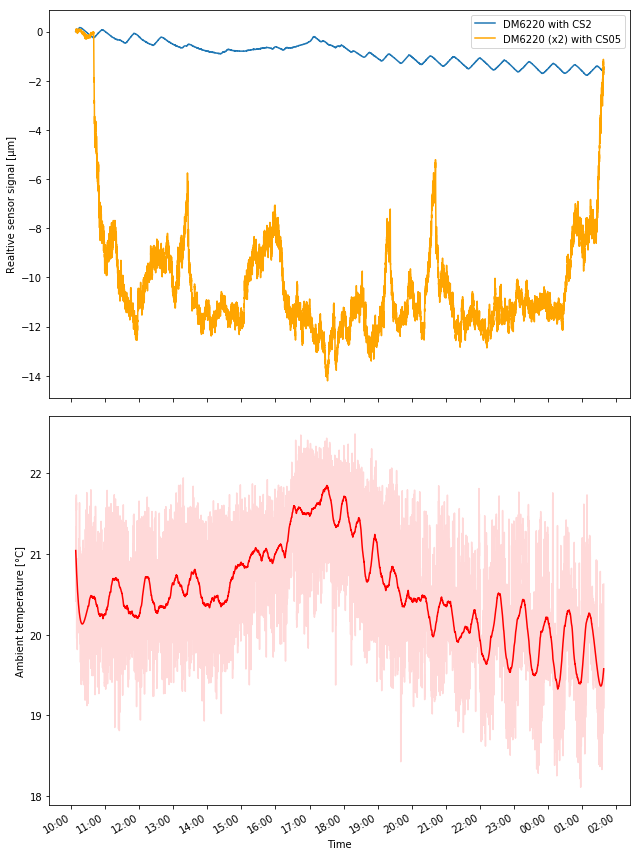

In [251]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9,12))
line0 = ax1.plot(y, z[0] - z[0][0], label="DM6220 with CS2")
line1 = ax1.plot(y, z[1] - z[1][0], color='orange', label="DM6220 (x2) with CS05")
ax1.legend()
ax2.plot(y, T, color=(1,0.85,0.85))
ax2.plot(y, T_filt, color='red')
ax1.xaxis.set_major_locator(HourLocator())
ax1.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax1.set_ylabel("Realtive sensor signal [µm]")
ax2.set_ylabel("Ambient temperature [°C]")
ax2.set_xlabel("Time")
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig('noise.png', dpi=200)

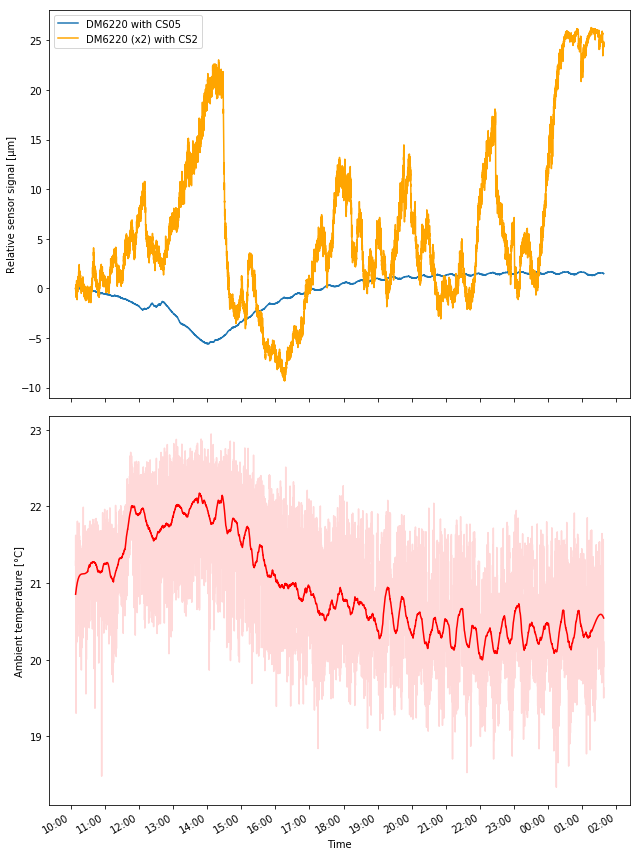

In [252]:
from matplotlib.dates import HourLocator, DateFormatter
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(9,12))
line0 = ax1.plot(y_swap, z_swap[0] - z_swap[0][0], label="DM6220 with CS05")
line1 = ax1.plot(y_swap, z_swap[1] - z_swap[1][0], color='orange', label="DM6220 (x2) with CS2")
ax2.plot(y_swap, T_swap, color=(1,0.85,0.85))
ax2.plot(y_swap, T_swap_filt, color='red')
ax1.legend()
ax1.xaxis.set_major_locator(HourLocator())
ax1.xaxis.set_major_formatter(DateFormatter("%H:%M"))
ax1.set_ylabel("Relative sensor signal [µm]")
ax2.set_ylabel("Ambient temperature [°C]")
ax2.set_xlabel("Time")
fig.autofmt_xdate()
fig.tight_layout()
fig.savefig('noise_swapped.png', dpi=200)

In [ ]:
len(z[0])